In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import pointcloud as PC
import CommChannel as CC
from importlib import reload 

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


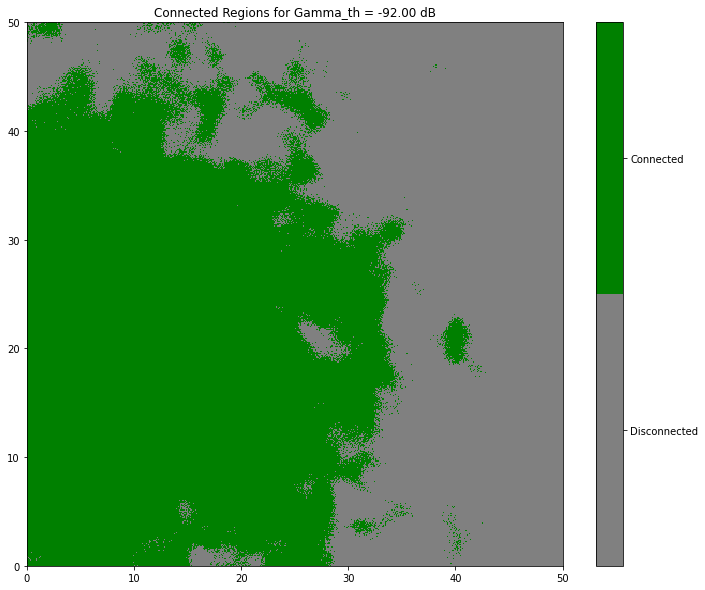

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


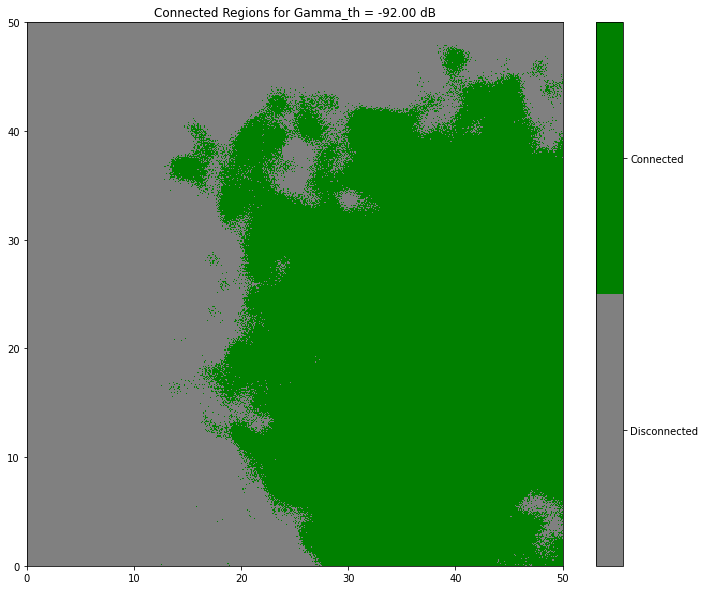

In [2]:
#Setup the system:

#For now, use same channel params
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[10,20],[40,20]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)
        cc.plotConnectivityField(-92)

In [3]:
#Create the predicted channel
pct_sample = 0.001
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))

Drawing 250 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2


In [8]:
reload(PC)

def indices_to_pts(r, region, res):
    #First get the non-zero indices
    idcs = np.array(np.where(r>0)).T
    pts = idcs - [region[1], region[3]]
    pts = pts/res
    return pts
p_th = 0.7
pcs[0].setPth(p_th)
pcs[1].setPth(p_th)
#plot the connectivity fields
cfs = [pc.getPConField(-90) for pc in pcs]
r = 1*((cfs[0]*cfs[1]) > p_th)
pts = indices_to_pts(r, region, res)
pointcloud = PC.PointCloud(pts)
pointcloud.partition(algo=4)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
28 total subregions


[<pointcloud.Poly at 0x7fc9608c90a0>, <pointcloud.Poly at 0x7fc9608c9070>]

Text(0.5, 1.0, 'Relay Region Decomposition')

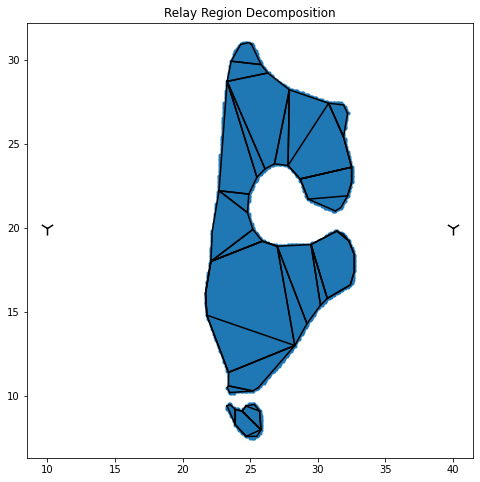

In [9]:
fig = plt.figure(figsize=(8,8))
pointcloud.plot('.')
pointcloud.plot_polys()
plt.scatter([qBase[0][0], qBase[1][0]], [qBase[0][1], qBase[1][1]],
                color='k', marker='1', s=200)

plt.title('Relay Region Decomposition')

In [6]:
raw_area = len(pts)*(1/res)**2
print('Original area: %.2f'%(raw_area))

reduced_area = 0
n_cnvx = 0
for poly in pointcloud.polygons:
    reduced_area += poly.area()
    n_cnvx += len(poly.cnvx_partition)
print('Area after reduction: %.2f'%(reduced_area))
print('Number of Convex Polygons in Partition: %d'%(n_cnvx))

Original area: 90.43
Area after reduction: 87.38
Number of Convex Polygons in Partition: 26


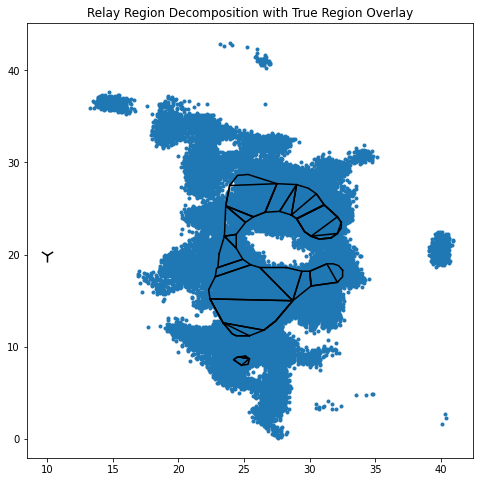

Original area: 246.92


In [7]:
#plot against the true channel
#plot the connectivity fields
fig = plt.figure(figsize=(8,8))
cfs = [cc.getConnectionField(-90) for cc in ccs]
r = cfs[0]*cfs[1]
pts = indices_to_pts(r, region, res)
plt.plot(pts[:,0], pts[:,1], '.')
pointcloud.plot_polys()
plt.scatter([qBase[0][0], qBase[1][0]], [qBase[0][1], qBase[1][1]],
                color='k', marker='1', s=200)

plt.title('Relay Region Decomposition with True Region Overlay')
plt.show()

raw_area = len(pts)*(1/res)**2
print('Original area: %.2f'%(raw_area))